![](https://europe-west1-atp-views-tracker.cloudfunctions.net/working-analytics?notebook=tutorials--langgraph-agent--langgraph-tutorial)

# LangGraph Tutorial: Building a Text Analysis Pipeline

## Introduction to LangGraph

LangGraph is a powerful framework by LangChain designed for creating stateful, multi-actor applications with LLMs. It provides the structure and tools needed to build sophisticated AI agents through a graph-based approach.

Think of LangGraph as an architect's drafting table - it gives us the tools to design how our agent will think and act. Just as an architect draws blueprints showing how different rooms connect and how people will flow through a building, LangGraph lets us design how different capabilities will connect and how information will flow through our agent.

### Key Features:
- **State Management:** Maintain persistent state across interactions
- **Flexible Routing:** Define complex flows between components
- **Persistence:** Save and resume workflows
- **Visualization:** See and understand your agent's structure

In this tutorial, we'll demonstrate LangGraph by building a multi-step text analysis pipeline that processes text through three stages:
1. **Text Classification:** Categorize input text into predefined categories
2. **Entity Extraction:** Identify key entities from the text
3. **Text Summarization:** Generate a concise summary of the input text

This pipeline showcases how LangGraph can be used to create a modular, extensible workflow for natural language processing tasks.

## Setting Up Our Environment

Before diving into the code, let's set up our development environment.

In [1]:
# Install required packages
!pip install langgraph langchain langchain-openai python-dotenv

  Using cached langchain-0.3.25-py3-none-any.whl.metadata (7.8 kB)
  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl.metadata (4.5 kB)
  Using cached langgraph_sdk-0.1.70-py3-none-any.whl.metadata (1.5 kB)
  Using cached langchain_text_splitters-0.3.8-py3-none-any.whl.metadata (1.9 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached h11-0.16.0-py3-none-any.wh

### Setting Up API Keys

We'll need an OpenAI API key to use their models. If you haven't already, you can get one from [https://platform.openai.com/signup](https://platform.openai.com/signup).

Let's load our environment variables:

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file (create this with your API key)
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Testing Our Setup

Let's make sure our environment is working correctly by creating a simple test with the OpenAI model:

In [3]:
from langchain_openai import ChatOpenAI

# Initialize the ChatOpenAI instance
llm = ChatOpenAI(model="gpt-4o-mini")

# Test the setup
response = llm.invoke("Hello! Are you working?")
print(response.content)

Hello! Yes, I'm here and ready to help you. What do you need assistance with today?


## Building Our Text Analysis Pipeline

Now let's import the necessary packages for our LangGraph text analysis pipeline:

In [4]:
import os
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

### Designing Our Agent's Memory

Just as human intelligence requires memory, our agent needs a way to keep track of information. We create this using a TypedDict to define our state structure:

In [5]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

# Initialize our language model with temperature=0 for more deterministic outputs
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Creating Our Agent's Core Capabilities

Now we'll create the actual skills our agent will use. Each of these capabilities is implemented as a function that performs a specific type of analysis.

#### 1. Classification Node

In [7]:
def classification_node(state: State):
    '''Classify the text into one of the categories: News, Blog, Research, or Other'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}

#### 2. Entity Extraction Node

In [8]:
def entity_extraction_node(state: State):
    '''Extract all the entities (Person, Organization, Location) from the text'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}

#### 3. Summarization Node

In [10]:
def summarization_node(state: State):
    '''Summarize the text in one short sentence'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}

### Bringing It All Together

Now comes the most exciting part - connecting these capabilities into a coordinated system using LangGraph:

In [11]:
# Create our StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node")  # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

### Visualizing the Workflow

One of the powerful features of LangGraph is the ability to visualize our workflow:

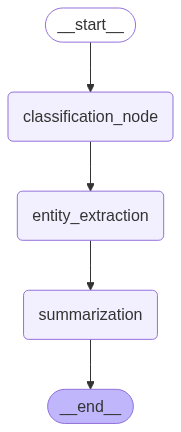

In [12]:
# Display a visualization of our graph
try:
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("The graph structure is: classification_node -> entity_extraction -> summarization -> END")

## Testing Our Agent

Now that we've built our agent, let's see how it performs with a real-world text example:

In [13]:
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
Additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: News

Entities: ['OpenAI', 'GPT-4', 'GPT-3']

Summary: OpenAI's upcoming GPT-4 model is a multimodal AI that aims for human-level performance and improved safety, efficiency, and scalability compared to GPT-3.


## Understanding the Power of Coordinated Processing

What makes this result particularly impressive isn't just the individual outputs - it's how each step builds on the others to create a complete understanding of the text.

- The **classification** provides context that helps frame our understanding of the text type
- The **entity extraction** identifies important names and concepts
- The **summarization** distills the essence of the document

This mirrors human reading comprehension, where we naturally form an understanding of what kind of text it is, note important names and concepts, and form a mental summary - all while maintaining the relationships between these different aspects of understanding.

## Try with Your Own Text

Now let's try our pipeline with another text sample of your choice:

In [14]:
# Replace this with your own text to analyze
your_text = """
The recent advancements in quantum computing have opened new possibilities for cryptography and data security. 
Researchers at MIT and Google have demonstrated quantum algorithms that could potentially break current encryption methods.
However, they are also developing new quantum-resistant encryption techniques to protect data in the future.
"""

# Process the text through our pipeline
your_result = app.invoke({"text": your_text})

print("Classification:", your_result["classification"])
print("\nEntities:", your_result["entities"])
print("\nSummary:", your_result["summary"])

Classification: Research

Entities: ['MIT', 'Google']

Summary: Recent advancements in quantum computing may threaten current encryption methods while also leading to the development of quantum-resistant techniques for future data security.


## Adding More Capabilities (Advanced)

One of the powerful aspects of LangGraph is how easily we can extend our agent with new capabilities. Let's add a sentiment analysis node to our pipeline:

In [15]:
# First, let's update our State to include sentiment
class EnhancedState(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
    sentiment: str

# Create our sentiment analysis node
def sentiment_node(state: EnhancedState):
    '''Analyze the sentiment of the text: Positive, Negative, or Neutral'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Analyze the sentiment of the following text. Is it Positive, Negative, or Neutral?\n\nText:{text}\n\nSentiment:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    sentiment = llm.invoke([message]).content.strip()
    return {"sentiment": sentiment}

# Create a new workflow with the enhanced state
enhanced_workflow = StateGraph(EnhancedState)

# Add the existing nodes
enhanced_workflow.add_node("classification_node", classification_node)
enhanced_workflow.add_node("entity_extraction", entity_extraction_node)
enhanced_workflow.add_node("summarization", summarization_node)

# Add our new sentiment node
enhanced_workflow.add_node("sentiment_analysis", sentiment_node)

# Create a more complex workflow with branches
enhanced_workflow.set_entry_point("classification_node")
enhanced_workflow.add_edge("classification_node", "entity_extraction")
enhanced_workflow.add_edge("entity_extraction", "summarization")
enhanced_workflow.add_edge("summarization", "sentiment_analysis")
enhanced_workflow.add_edge("sentiment_analysis", END)

# Compile the enhanced graph
enhanced_app = enhanced_workflow.compile()

### Testing the Enhanced Agent

In [16]:
# Try the enhanced pipeline with the same text
enhanced_result = enhanced_app.invoke({"text": sample_text})

print("Classification:", enhanced_result["classification"])
print("\nEntities:", enhanced_result["entities"])
print("\nSummary:", enhanced_result["summary"])
print("\nSentiment:", enhanced_result["sentiment"])

Classification: News

Entities: ['OpenAI', 'GPT-4', 'GPT-3']

Summary: OpenAI's upcoming GPT-4 model is a multimodal AI that aims for human-level performance and improved safety, efficiency, and scalability compared to GPT-3.

Sentiment: The sentiment of the text is Positive. It highlights the advancements and improvements of the GPT-4 model, emphasizing its human-level performance, efficiency, scalability, and the positive implications for AI alignment and safety. The anticipation of its release for public use further contributes to the positive tone.


## Conclusion

In this tutorial, we've:

1. Explored LangGraph concepts and its graph-based approach
2. Built a text processing pipeline with classification, entity extraction, and summarization
3. Enhanced our pipeline with additional capabilities
4. Visualized our workflow
5. Tested our agent with real-world text examples

LangGraph provides a powerful framework for creating AI agents by modeling them as graphs of capabilities. This approach makes it easy to design, modify, and extend complex AI systems.

### Next Steps

- Add more nodes to extend your agent's capabilities
- Create conditional edges to enable more complex decision-making
- Experiment with different LLMs and parameters
- Explore LangGraph's state persistence features for ongoing conversations

For more information, check out the official LangGraph documentation at https://langchain-ai.github.io/langgraph/